<a href="https://colab.research.google.com/github/hemhemoh/Financial-Resilience/blob/main/UmojaHack21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Train.csv")
test = pd.read_csv("/content/drive/MyDrive/Test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/SampleSubmission.csv")

In [ ]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [ ]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,009D84L,2010-04-24,2011-03-27,NO GENDER,25,2010-04-24,1,NaN,As Attached,Iveco,Victoria Island,Lagos,CVTP
1,01DO2EQ,2010-01-01,2010-12-31,NaN,120,2010-01-01,4,NaN,As Attached,TOYOTA,Victoria Island,Lagos,Muuve
2,01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
3,024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
4,02BYET3,2010-09-16,2010-12-31,NaN,120,2010-09-16,4,NaN,NaN,TOYOTA,Victoria Island,Lagos,Muuve


In [ ]:
sample_submission.head()

,ID,target
0,009D84L,0
1,01DO2EQ,0
2,01QM0NU,0
3,024NJLZ,0
4,02BYET3,0


In [ ]:
print('Train shape:',train.shape,'\nTest shape:', test.shape, '\nsamplesubmission shape:',sample_submission.shape)

Train shape: (12079, 14) 
Test shape: (5177, 13) 
samplesubmission shape: (5177, 2)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      5177 non-null   object
 1   Policy Start Date       5177 non-null   object
 2   Policy End Date         5177 non-null   object
 3   Gender                  5021 non-null   object
 4   Age                     5177 non-null   int64 
 5   First Transaction Date  5177 non-null   object
 6   No_Pol                  5177 non-null   int64 
 7   Car_Category            3539 non-null   object
 8   Subject_Car_Colour      2172 non-null   object
 9   Subject_Car_Make        4116 non-null   object
 10  LGA_Name                2395 non-null   object
 11  State                   2389 non-null   object
 12  ProductName             5177 non-null   object
dtypes: int64(2), object(11)
memory usage: 525.9+ KB


In [ ]:
# join train and test together
ntrain = train.shape[0]
ntest = test.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (17256, 14)


In [ ]:
all_data = all_data.drop(columns=["ID", "First Transaction Date"], axis=1)

In [ ]:
date_col = ['Policy Start Date','Policy End Date']
num_col = ['Age']
cat_col = [col for col in test.columns if col not in date_col+num_col]
cat_col

['ID',
 'Gender',
 'First Transaction Date',
 'No_Pol',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']

In [ ]:
cat_col.remove('ID')

In [ ]:
train.describe()

,Age,No_Pol,target
count,12079.000000,12079.000000,12079.000000
mean,42.234539,1.307227,0.120457
std,97.492565,0.733085,0.325509
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


In [ ]:
all_data.head()

,Policy Start Date,Policy End Date,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,2010-05-14,2011-05-13,Male,30,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,2010-11-29,2011-11-28,Female,79,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,2010-03-21,2011-03-20,Male,43,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,2010-08-21,2011-08-20,Male,2,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0
4,2010-08-29,2010-12-31,Entity,20,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1.0


In [ ]:
def check_categorical_relationship(cat_col,y_col,df):
    for feat in cat_col:
        plt.figure(figsize=(20,5))
        sns.barplot(df[feat],df[y_col])
        plt.show()
        print("\n \n \n ")

In [ ]:
all_data.Gender.unique()

array(['Male', 'Female', 'Entity', 'Joint Gender', nan, 'NO GENDER',
       'NOT STATED', 'SEX'], dtype=object)

In [ ]:
all_data = all_data.fillna("9999")
all_data.head()

,Policy Start Date,Policy End Date,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,2010-05-14,2011-05-13,Male,30,1,Saloon,Black,TOYOTA,999,999,Car Classic,0
1,2010-11-29,2011-11-28,Female,79,1,JEEP,Grey,TOYOTA,999,999,Car Classic,1
2,2010-03-21,2011-03-20,Male,43,1,Saloon,Red,TOYOTA,999,999,Car Classic,0
3,2010-08-21,2011-08-20,Male,2,1,999,999,999,999,999,CarSafe,0
4,2010-08-29,2010-12-31,Entity,20,3,999,999,999,Lagos,Lagos,Muuve,1


In [ ]:
print("Are There still Missing value in data? :",all_data.isnull().any().any())
print((all_data.isnull().sum()/all_data.shape[0])*100)

Are There still Missing value in data? : False
Policy Start Date     0.0
Policy End Date       0.0
Gender                0.0
Age                   0.0
No_Pol                0.0
Car_Category          0.0
Subject_Car_Colour    0.0
Subject_Car_Make      0.0
LGA_Name              0.0
State                 0.0
ProductName           0.0
target                0.0
dtype: float64


In [ ]:
date_col

['Policy Start Date', 'Policy End Date']

In [ ]:
for feat in date_col:
    all_data[feat] = pd.to_datetime(all_data[feat])

In [ ]:
def extract_date_info(df,cols,):
    for feat in cols:
        df[feat +'_year'] = df[feat].dt.quarter
        df[feat +'_day'] = df[feat].dt.day
        df[feat +'_month'] = df[feat].dt.month
        df[feat +'_quarter'] = df[feat].dt.quarter
    df.drop(columns=date_col,axis=1,inplace=True)

In [ ]:
extract_date_info(all_data,date_col)

In [ ]:
all_data.head()

,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Date_year,Policy Start Date_day,Policy Start Date_month,Policy Start Date_quarter,Policy End Date_year,Policy End Date_day,Policy End Date_month,Policy End Date_quarter
0,Male,30,1,Saloon,Black,TOYOTA,999,999,Car Classic,0,2,14,5,2,2,13,5,2
1,Female,79,1,JEEP,Grey,TOYOTA,999,999,Car Classic,1,4,29,11,4,4,28,11,4
2,Male,43,1,Saloon,Red,TOYOTA,999,999,Car Classic,0,1,21,3,1,1,20,3,1
3,Male,2,1,999,999,999,999,999,CarSafe,0,3,21,8,3,3,20,8,3
4,Entity,20,3,999,999,999,Lagos,Lagos,Muuve,1,3,29,8,3,4,31,12,4


In [ ]:
all_data.Gender.unique()

array(['Male', 'Female', 'Entity', 'Joint Gender', '999', 'NO GENDER',
       'NOT STATED', 'SEX'], dtype=object)

In [ ]:
mapper = {"Male":"M","Female":'F','Entity':'O','Joint Gender':'O',"9999":'O','NO GENDER':'O','NOT STATED':'O','SEX':'O' }

In [ ]:
all_data.Gender = all_data.Gender.map(mapper)

In [ ]:
all_data.Gender.unique()

array([nan], dtype=object)

In [ ]:
# pd.get_dummies(all_data)

In [ ]:
all_data.target = all_data.target.astype(int)

In [ ]:
#Get the new dataset
train_n = all_data[:ntrain]
test_n = all_data[ntrain:]

In [ ]:
test_n.drop("target",axis = 1,inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X= train_n.drop(columns=['target'])
y= train_n.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42,)

In [ ]:
test_n.columns

Index(['Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Colour',
       'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName',
       'Policy Start Date_year', 'Policy Start Date_day',
       'Policy Start Date_month', 'Policy Start Date_quarter',
       'Policy End Date_year', 'Policy End Date_day', 'Policy End Date_month',
       'Policy End Date_quarter'],
      dtype='object')

In [ ]:
#categorical_feat = ['Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Colour',
       #'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName']

In [ ]:
#categorical_feat

In [ ]:
le = LabelEncoder()

In [ ]:

all_data["Subject_Car_Make"] = le.fit_transform(all_data["Subject_Car_Make"])
all_data["LGA_Name"] = le.fit_transform(all_data["LGA_Name"])
all_data["State"] = le.fit_transform(all_data["State"])
all_data["ProductName"] = le.fit_transform(all_data["ProductName"])

In [ ]:

all_data["No_Pol"] = le.fit_transform(all_data["No_Pol"])
all_data["Car_Category"] = le.fit_transform(all_data["Car_Category"])
all_data["Subject_Car_Colour"] = le.fit_transform(all_data["Subject_Car_Colour"])

In [ ]:
all_data["Gender"] = le.fit_transform(all_data["Gender"])

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostClassifier
import catboost
model = CatBoostClassifier(learning_rate=0.07,thread_count=-1,bagging_temperature=0.8609)

In [ ]:
model.fit(X_train,y_train)

0:	learn: 0.6231634	total: 53.2ms	remaining: 53.2s
1:	learn: 0.5579336	total: 59.2ms	remaining: 29.5s
2:	learn: 0.5242990	total: 64.8ms	remaining: 21.5s
3:	learn: 0.4959774	total: 70.3ms	remaining: 17.5s
4:	learn: 0.4698312	total: 75.5ms	remaining: 15s
5:	learn: 0.4454969	total: 80.9ms	remaining: 13.4s
6:	learn: 0.4283169	total: 86.3ms	remaining: 12.2s
7:	learn: 0.4034913	total: 91.8ms	remaining: 11.4s
8:	learn: 0.3913509	total: 97ms	remaining: 10.7s
9:	learn: 0.3740222	total: 102ms	remaining: 10.1s
10:	learn: 0.3639175	total: 108ms	remaining: 9.69s
11:	learn: 0.3561615	total: 113ms	remaining: 9.31s
12:	learn: 0.3504572	total: 120ms	remaining: 9.08s
13:	learn: 0.3431517	total: 126ms	remaining: 8.9s
14:	learn: 0.3367292	total: 133ms	remaining: 8.72s
15:	learn: 0.3334596	total: 138ms	remaining: 8.5s
16:	learn: 0.3266803	total: 144ms	remaining: 8.3s
17:	learn: 0.3230753	total: 149ms	remaining: 8.14s
18:	learn: 0.3204723	total: 155ms	remaining: 7.98s
19:	learn: 0.3182053	total: 160ms	remai

In [ ]:
y_pred = model.predict(X_train)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['class 0', 'class 1']
print('*************** Classification report on training set ********************')
print(classification_report(y_train, y_pred, target_names=target_names))

*************** Classification report on training set ********************
              precision    recall  f1-score   support

     class 0       0.93      0.99      0.96      8513
     class 1       0.87      0.49      0.62      1150

    accuracy                           0.93      9663
   macro avg       0.90      0.74      0.79      9663
weighted avg       0.93      0.93      0.92      9663



In [ ]:
print('*************** Classification report on testing set ********************')
print(classification_report(y_test, model.predict(X_test), target_names=target_names))

*************** Classification report on testing set ********************
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.92      2111
     class 1       0.30      0.14      0.19       305

    accuracy                           0.85      2416
   macro avg       0.59      0.55      0.56      2416
weighted avg       0.81      0.85      0.83      2416



In [ ]:
model.fit(X,y)

0:	learn: 0.6249348	total: 7.93ms	remaining: 7.92s
1:	learn: 0.5595974	total: 17.7ms	remaining: 8.83s
2:	learn: 0.5251581	total: 27.2ms	remaining: 9.04s
3:	learn: 0.4969142	total: 35.9ms	remaining: 8.93s
4:	learn: 0.4568281	total: 44.9ms	remaining: 8.94s
5:	learn: 0.4348275	total: 53.6ms	remaining: 8.87s
6:	learn: 0.4190609	total: 62ms	remaining: 8.8s
7:	learn: 0.3975657	total: 70.6ms	remaining: 8.75s
8:	learn: 0.3861638	total: 79.4ms	remaining: 8.74s
9:	learn: 0.3706498	total: 88.6ms	remaining: 8.77s
10:	learn: 0.3624082	total: 97.5ms	remaining: 8.76s
11:	learn: 0.3549153	total: 107ms	remaining: 8.78s
12:	learn: 0.3490598	total: 115ms	remaining: 8.75s
13:	learn: 0.3441718	total: 124ms	remaining: 8.74s
14:	learn: 0.3397503	total: 133ms	remaining: 8.75s
15:	learn: 0.3325247	total: 142ms	remaining: 8.76s
16:	learn: 0.3289754	total: 151ms	remaining: 8.74s
17:	learn: 0.3259689	total: 160ms	remaining: 8.73s
18:	learn: 0.3231730	total: 169ms	remaining: 8.74s
19:	learn: 0.3207805	total: 179ms

In [ ]:
set(test.ID == sample_submission.ID)

{True}

In [ ]:
prediction = model.predict(test_n)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


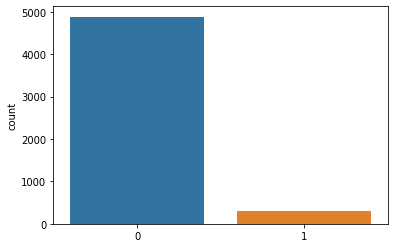

In [ ]:
sns.countplot(prediction)

In [ ]:
sample_submission.head()

,ID,target
0,009D84L,0
1,01DO2EQ,0
2,01QM0NU,0
3,024NJLZ,0
4,02BYET3,0


In [ ]:
sub_file = sample_submission.copy()

In [ ]:
sub_file.target = prediction

In [ ]:
sub_file.to_csv('base_model_pred_file.csv',index=False)